In [1]:
%load_ext notexbook
%load_ext watermark

In [2]:
%texify

<span class="badges">

[![myBinder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/leriomaggio/deep-unsupervised-learning/HEAD?filepath=3_Dimensionality_Reduction/4%20UMAP%20for%20Clustering.ipynb)
    
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leriomaggio/deep-unsupervised-learning/blob/main/3_Dimensionality_Reduction/4%20UMAP%20for%20Clustering.ipynb)

[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/leriomaggio/deep-unsupervised-learning/blob/main/3_Dimensionality_Reduction/4%20UMAP%20for%20Clustering.ipynb)
</span>

# UMAP for Clustering

<span><i>Adapted from: </i> _Using UMAP for Clustering_ [(Ref)](https://umap-learn.readthedocs.io/en/latest/clustering.html)</span>

## Preamble (to keep in mind)

`UMAP` can be used as an effective preprocessing step to boost the
performance of density based clustering. 

This is somewhat controversial, and should be attempted with care. 
For a good discussion of some of the issues involved in this, please see the various answers in [this](https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne)
stackoverflow
thread on clustering the results of t-SNE. 

Many of the points of concern raised there are salient for clustering the results of UMAP. 
The most notable is that UMAP, like t-SNE, does not completely preserve density. 
UMAP, like t-SNE, can also create false tears in clusters, resulting in a 
finer clustering than is necessarily present in the data. 

Despite these concerns there are still valid reasons to use UMAP as a preprocessing step for clustering. As with any clustering approach one will want to do some exploration and evaluation of the
clusters that come out to try to validate them if possible.

With all of that said, let's work through an example to demonstrate the
difficulties that can face clustering approaches and how UMAP can
provide a powerful tool to help overcome them.

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import hdbscan

%watermark -iv
%matplotlib inline

hdbscan   : 0.8.27
matplotlib: 3.4.1
seaborn   : 0.11.1
umap      : 0.5.1
numpy     : 1.20.2



In [4]:
sns.set(style='white', rc={'figure.figsize':(10,8)})

Also, since we are going to work with labelled data, we can rely on _strong_ cluster evaluation metrics such as [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index) and [Adjusted Mutual Information](https://en.wikipedia.org/wiki/Adjusted_mutual_information)

In [5]:
# Dimension reduction and clustering libraries
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [6]:
from umap import plot as umap_plot

###### Load MNIST dataset

In [7]:
# Set this flag to False and re-run the whole notebook to use 
# the Digits "Toy" dataset
USE_HIGH_RESOLUTION_DATA = True  # Using High-res by default

In [8]:
if USE_HIGH_RESOLUTION_DATA:
    # mnist_784 is the name of the dataset in OpenML
    # This may take some time depending on your internet connection
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    y = y.astype(int)
else:
    X, y = load_digits(return_X_y=True)

In [9]:
# Showing shapes of data
X.shape, y.shape

((70000, 784), (70000,))

In [10]:
# Convert into NumPy arrays
X = X.to_numpy()
y = y.to_numpy()

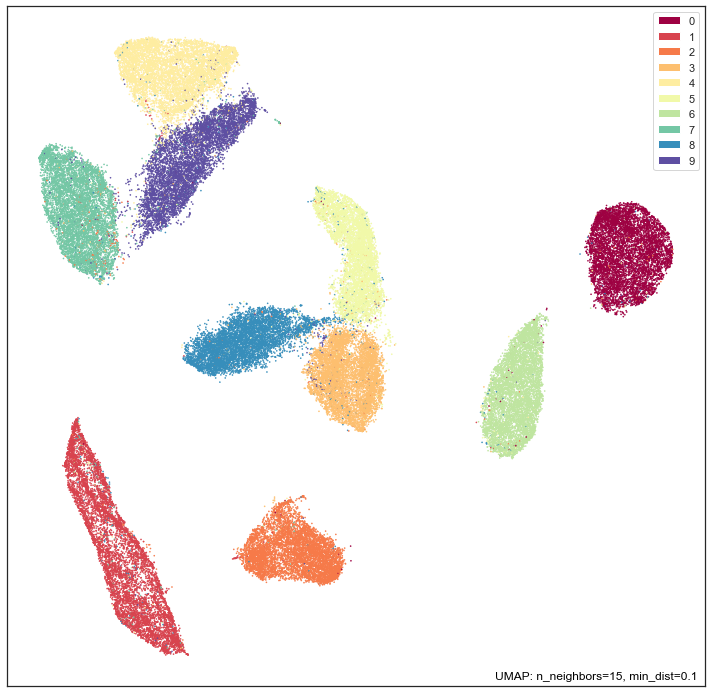

In [11]:
mapper = umap.UMAP(random_state=123456).fit(X)
umap_plot.points(mapper, labels=y, width=900, height=900)
plt.show()

## Traditional Clustering

Now we would like to cluster the data. 

As a first attempt let’s try the traditional approach: `K-Means`. 

In this case we can solve one of the **hard problems** for `K-Means` clustering – choosing the right `k` value, giving the number of clusters we are looking for. 

In this case we know the answer is exactly `10`. 

We will use `sklearn`'s `K-Means` implementation looking for `10` clusters in the original `784` dimensional data.

In [12]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(X)

Let's see now how well we did, this time using labels generated by the clustering algo

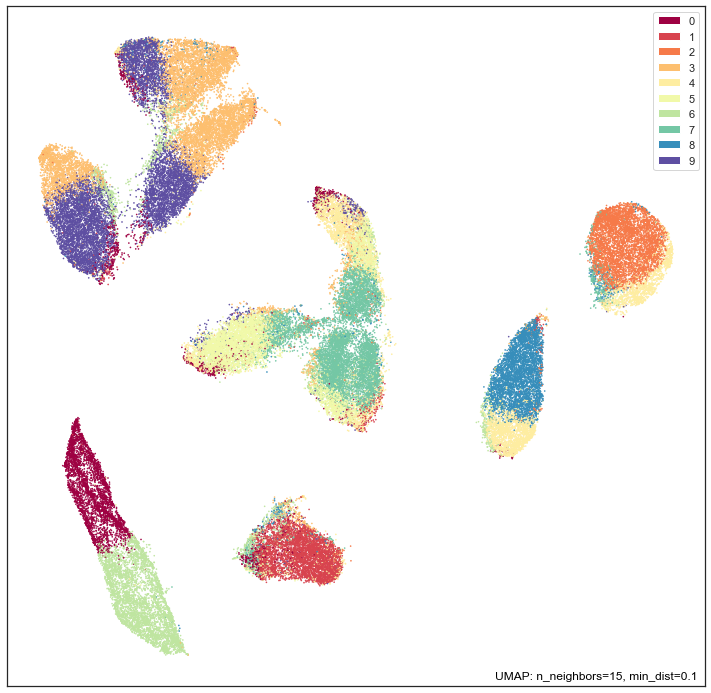

In [13]:
umap_plot.points(mapper, labels=kmeans_labels, width=900, height=900)
plt.show()

This is not _exactly_ the result we were looking for (though it does expose interesting properties of how `K-Means` chooses clusters in high dimensional space, and how `UMAP` unwraps manifolds by finding manifold boundaries). 

While `K-Means` gets some cases correct, such as the two clusters on the right side which are mostly correct, most of the rest of the data looks somewhat arbitrarily carved up among the remaining clusters. 

We can put this impression to the test by evaluating the `adjusted rand score` and `adjusted mutual information` for this clustering as compared with the true labels.

In [14]:
true_labels = y
adjusted_rand_score(true_labels, kmeans_labels),

(0.3662957676117355,)

In [15]:
adjusted_mutual_info_score(true_labels, kmeans_labels)

0.49945653455318734

As might be expected, we have **not** done a particularly good job – both scores take values in the range `0` to `1`, with `0` representing a **bad** (essentially random) clustering and `1` representing perfectly recovering the true labels.

K-Means definitely was not random, but it was also quite a long way from perfectly recovering the true labels.

Part of the problem is the way `K-Means` works, based on centroids with an assumption of largely spherical clusters. 

We can potentially improve on this by using a _smarter_ density based algorithm, e.g. `HDBSCAN`. 

**Note**: For the sake of performance we will reduce the dimensionality of the data down to `50` dimensions via `PCA` (this recovers most of the variance), since `HDBSCAN` scales somewhat poorly with the dimensionality of the data.

In [16]:
lowd_mnist = PCA(n_components=50).fit_transform(X)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_mnist)

We can now inspect the results. 

Before we do, however, it should be noted that one of the features of `HDBSCAN` is that it can refuse to cluster some points and classify them as **noise**. 

To visualize this aspect we will color points that were classified as **noise** gray, and then color the remaining points according to the cluster membership.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


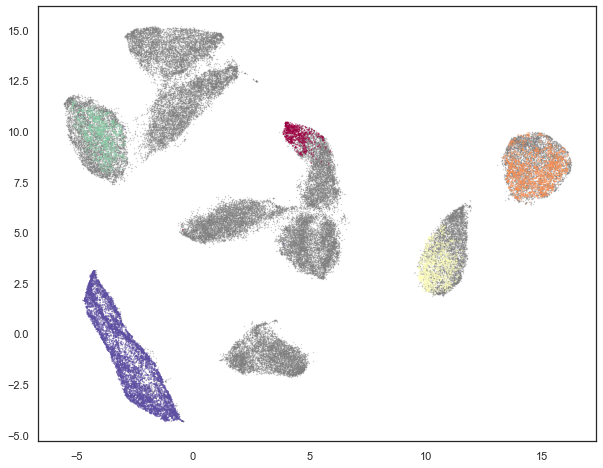

In [17]:
clustered = (hdbscan_labels >= 0)
standard_embedding = mapper.transform(X)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');
plt.show()

This looks somewhat underwhelming. It meets HDBSCAN’s approach of “not being wrong” by simply refusing to classify the majority of the data.

In [18]:
adjusted_rand_score(true_labels, hdbscan_labels), adjusted_mutual_info_score(true_labels, hdbscan_labels)

/Users/valerio/anaconda3/envs/unsupervised/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))


(-0.32891336932707066, 0.30599368318062137)

These score are far worse than K-Means. However: 

In [19]:
clustered = (hdbscan_labels >= 0)
adjusted_rand_score(true_labels[clustered], hdbscan_labels[clustered])

0.9985063360093697

In [20]:
adjusted_mutual_info_score(true_labels[clustered], hdbscan_labels[clustered])

0.9961936143540825

How much of the data did HDBSCAN actually assign to clusters? We can compute that easily enough.

In [21]:
np.sum(clustered) / X.shape[0]

0.16992857142857143

t seems that less than 18% of the data was clustered. While HDBSCAN did a great job on the data it could cluster it did a poor job of actually managing to cluster the data. The problem here is that, as a density based clustering algorithm, HDBSCAN tends to suffer from the **curse of dimensionality**: high dimensional data requires more observed samples to produce much density.

If we could reduce the dimensionality of the data more we would make the density more evident and make it far easier for HDBSCAN to cluster the data. 

The problem is that trying to use `PCA` to do this is going to become problematic. 

While reducing the `50` dimensions still explained a lot of the variance of the data, reducing further is going to quickly do a lot worse. 
This is due to the _linear_ nature of `PCA`. 

What we would is a strong **manifold learning** method, and this is where `UMAP` can come into play.




### UMAP enhanced Clustering

Our goal is to make use of `UMAP` to perform non-linear manifold aware dimension reduction so we can get the dataset down to a number of dimensions small enough for a density based clustering algorithm to make progress. 

One **advantage** of `UMAP` for this is that it doesn’t require you to reduce to only two dimensions – you can reduce to `10` dimensions instead since the goal is to cluster, not visualize, and the performance cost with UMAP is minimal. 

As it happens `MNIST` is such a simple dataset that we really can push it all the way down to only two dimensions, but in general you should explore **different** embedding dimension options.

The next thing to be aware of is that when using `UMAP` for dimension reduction you will want to select different parameters than if you were using it for visualization. 

First of all we will want a larger `n_neighbors` value – small values will focus more on very local structure and so prone to error as in the case of `hdbscan`. In this case we will double it from the default `15` up to `30`. 

Second it is beneficial to set `min_dist` to a very low value: since we actually want to pack points together densely (density is what we want after all) a low value will help, as well as making cleaner separations between clusters. In this case we will simply set `min_dist` to be `0`.

In [22]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=123456,
).fit_transform(X)

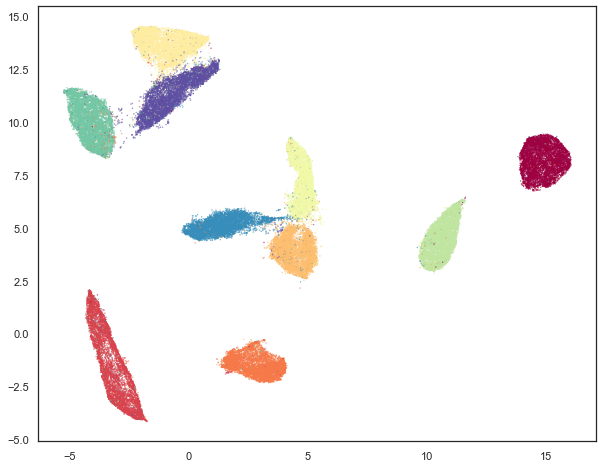

In [23]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=true_labels, s=0.1, cmap='Spectral');
plt.show()

The next step is to cluster this data. We’ll use HDBSCAN again, with the same parameter setting as before.

In [24]:
umap_hdbscan_labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

And now we can visualise the results:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


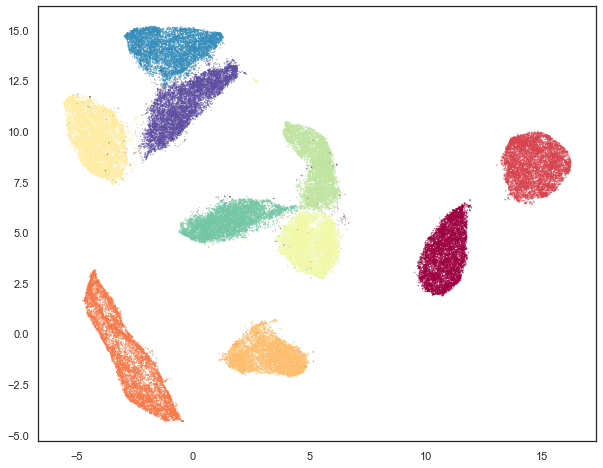

In [25]:
clustered = (umap_hdbscan_labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=umap_hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');

In [26]:
adjusted_rand_score(true_labels, umap_hdbscan_labels)

0.9282532426165478

In [27]:
adjusted_mutual_info_score(true_labels, umap_hdbscan_labels)

0.9135015551346987

If we limit the calculations to those clustered

In [28]:
adjusted_rand_score(true_labels[clustered], umap_hdbscan_labels[clustered])

0.9316125112056853

In [29]:
adjusted_mutual_info_score(true_labels[clustered], umap_hdbscan_labels[clustered])

0.9186629959961197

In [30]:
np.sum(clustered) / true_labels.shape[0]

0.9966857142857143

Now we are clustering over `99%` of the data! 

And our results in terms of `adjusted Rand score` and `adjusted mutual information` are in line with the current state of the art techniques using **convolutional autoencoder techniques**. 

That’s not bad for an approach that is simply viewing the data as arbitrary `784` dimensional vectors!

#### Before Closing this section...

Speaking of _convolutional autoencoder_, here is an hint for what will be covered in the next section and how can we combine with UMAP too: [Parametric UMAP](https://umap-learn.readthedocs.io/en/latest/parametric_umap.html)

![parametric umap](https://umap-learn.readthedocs.io/en/latest/_images/pumap-only.png)